In [174]:
cd six/

[Errno 2] No such file or directory: 'six/'
/home/wa/jupyter/six


In [557]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

station = pd.read_csv("201608_station_data.csv", sep=',', parse_dates=["installation"])
status = pd.read_csv("ten.csv", sep=',', parse_dates=["time"])
trip = pd.read_csv("201608_trip_data.csv", sep=',')
weather = pd.read_csv("201608_weather_data.csv", sep=',',parse_dates=["PDT"])

piyo = weather

station = station.dropna()
station[["station_id","dockcount"]] = station[["station_id","dockcount"]].astype(int)
trip["day"] = pd.to_datetime(trip["Start Date"]).dt.normalize()
trip['hour'] = pd.to_datetime(trip['Start Date']).dt.hour
trip["Subscriber Type"] = trip["Subscriber Type"].replace('Subscriber', 0).replace('Customer', 1)
weather.PrecipitationIn = weather.PrecipitationIn.replace('T', 0.005).astype(float)
weather.ZIP = weather.ZIP.replace(94107, 'San Francisco').replace(94063, 'Redwood City').replace(94301, 'Palo Alto'
                                ).replace(94041, 'Mountain View').replace(95113, 'San Jose')
weather.rename(columns={'ZIP': 'landmark', 'PDT':'day'},inplace=True)

In [558]:
sta = station[["station_id", "landmark",'lat', 'long']]
start = sta.rename(columns={'station_id':'Start Terminal', 'landmark':'Start City', 'lat':'start_lat', 'long':'start_long'})
end = sta.rename(columns={'station_id': 'End Terminal', 'landmark':'End City', 'lat':'end_lat', 'long':'end_long'})

status['use_rate'] = status.docks_available / (status.docks_available + status.bikes_available)
status['day'] = pd.to_datetime(status.time.dt.date)
status['hour'] = status.time.dt.hour
status['youbi'] = status.day.dt.weekday 

voy = trip[["day",'hour', "Start Terminal", "End Terminal", "Duration","Subscriber Type"]]
tenki = weather[["day", "Mean TemperatureF"," Mean Humidity"," Mean Sea Level PressureIn",
                 " Mean VisibilityMiles", " Mean Wind SpeedMPH","PrecipitationIn", " CloudCover", "landmark"]]


In [559]:
status = pd.merge(status, sta, how='left', on=['station_id'])
status = pd.merge(status, tenki, how='left', on=['day', 'landmark']) #statusの各駅に都市名と天気を追加したもの

tenki2 = tenki.rename(columns={'landmark':'Start City'})
tmp = pd.merge(voy, start,how='left',on='Start Terminal')
voy_city = pd.merge(tmp, end, how='left', on='End Terminal')
data = pd.merge(voy_city, tenki2, how='left', on=['day', 'Start City']).dropna()
data['dis'] = abs(data.start_lat - data.end_lat) + abs(data.start_long - data.end_long)
data['youbi'] = data.day.dt.weekday
data['mon'] = data.day.dt.month
#tripに都市名と天気と距離を追加したもの

In [1009]:
#重回帰分析の下準備

city = 'San Francisco'
tmp40=data[data['Start City']==city].groupby('day').Duration.count().reset_index()
tmp40.rename(columns={'Duration':'cnt'},inplace=True)
tmp40['youbi']=tmp40.day.dt.weekday
tmp40['mon'] = tmp40.day.dt.month
tmp40['weekend'] = tmp40.youbi.apply(lambda x: 1 if(x >= 5) else 0)
tmp40['edge'] = tmp40.youbi.apply(lambda x:
                                  1 if(x == 0 or x == 4) else 0)

hoge = tmp40
otenki=tenki[tenki.landmark==city][['day', 'PrecipitationIn']]
tmp40=pd.merge(tmp40, otenki, how='left')
tmp40['rain'] = tmp40.PrecipitationIn.apply(lambda x: 1 if(x > 0) else 0)

In [1015]:
#重回帰分析
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

hoge=pd.merge(hoge,tenki[tenki.landmark==city], how='left')
hoge['rain'] = hoge.PrecipitationIn.apply(
    lambda x: 1 if(x > 0) else 0)

ttt0 = 0
ttt1 = 0
ttt2 = 0
ttt3 = 0
ttt4 = 0
ttt5 = 0
ttt6 = 0
sc = StandardScaler()

for i in range(2000):
    l_model = linear_model.LinearRegression()
    X = hoge[['weekend', 'edge', 'Mean TemperatureF','PrecipitationIn' ,'rain']]
    Y = hoge.cnt

    X_train, X_test, y_train, y_test = train_test_split(
        X, Y, test_size=0.2, random_state=i)

    #sc.fit(X_train)
    #X_train = sc.transform(X_train)
    #X_test = sc.transform(X_test)

    clf =l_model.fit(X_train, y_train)
 
    ttt0 += clf.score(X_test, y_test)
    ttt1 += clf.coef_[0]
    ttt2 += clf.coef_[1]
    ttt3 += clf.coef_[2]
    ttt4 += clf.coef_[3]
    ttt5 += clf.coef_[4]
    ttt6 += clf.intercept_

#print ('train:', clf.score(X_train, y_train))
#print ('test:', clf.score(X_test, y_test))

#print (pd.DataFrame({'Name':X.columns,
            #'Coefs':clf.coef_}).sort_values(by='Coefs'))

#print(clf.intercept_)
print (ttt0 / 2000, ttt1/2000, ttt2/2000, ttt3/2000, ttt4/2000, ttt5/2000, ttt6/2000)

0.818582465788 -809.51858562 -122.24677452 12.241001114 -302.164717338 -98.9220634689 342.110992147


In [887]:
tmp50=data.groupby(['Start Terminal', 'End Terminal']).day.count(
    ).sort_values(ascending=False).reset_index(
    ).rename(columns={'day':'times'}) #駅間移動ランキング
pd.merge(tmp50, start, how='left').head(5)

,Start Terminal,End Terminal,times,Start City,start_lat,start_long
0,65,69,3341,San Francisco,37.771058,-122.402717
1,67,69,3035,San Francisco,37.776619,-122.417385
2,50,60,2986,San Francisco,37.795392,-122.394203
3,61,50,2781,San Francisco,37.780526,-122.390288
4,60,74,2605,San Francisco,37.804770,-122.403234


In [512]:
status[status.youbi==6].groupby([
    'station_id', 'hour']).use_rate.mean().unstack(
    ).T.max().sort_values(ascending=False).head()
#平日の最大使用率上位ランキング

station_id
91    0.914286
62    0.794414
45    0.728736
63    0.718797
57    0.713333
dtype: float64

In [983]:
jikei=status.groupby(['station_id','hour']).use_rate.mean().unstack().T
tmp20=(jikei.max()-jikei.min()).sort_values(ascending=False).reset_index()
tmp21=pd.merge(tmp20, sta, how='left') #日較差の大きいstation
tmp21[tmp21[0]>0.3].head()

,station_id,0,landmark,lat,long
0,70,0.494564,San Francisco,37.776617,-122.395260
1,69,0.489841,San Francisco,37.776600,-122.395470
2,90,0.397849,San Francisco,37.780148,-122.403158
3,73,0.395321,San Francisco,37.797900,-122.405942
4,50,0.385273,San Francisco,37.795392,-122.394203


In [985]:
tmp20=jikei.max().sort_values(ascending=False).reset_index()
tmp21=pd.merge(tmp20, sta, how='left').head()
tmp21.rename(columns={0:'use_rate'})
 #平均最大使用率の高い順

,station_id,use_rate,landmark,lat,long
0,91,0.904762,San Francisco,37.785908,-122.408891
1,62,0.790143,San Francisco,37.785299,-122.396236
2,45,0.789843,San Francisco,37.794231,-122.402923
3,89,0.776316,San Jose,37.332398,-121.890429
4,63,0.766514,San Francisco,37.786978,-122.398108


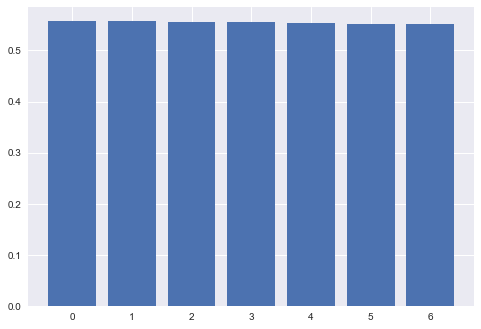

In [982]:
tmp50 = status.groupby('youbi').mean()
plt.bar(tmp50.index, tmp50.use_rate)
plt.show()

In [997]:
tmp30 = status[status.bikes_available == 0].groupby('station_id').count().sort_values(by='use_rate', ascending=False).reset_index()
tmp30=tmp30[['station_id', 'day']]
tmp40=pd.merge(tmp30, sta, how='left').rename(columns={'day':'zero'})
tmp40.head()
#機会損失ランキング

,station_id,zero,landmark,lat,long
0,62,202,San Francisco,37.785299,-122.396236
1,45,152,San Francisco,37.794231,-122.402923
2,63,140,San Francisco,37.786978,-122.398108
3,41,132,San Francisco,37.795001,-122.399970
4,73,119,San Francisco,37.797900,-122.405942


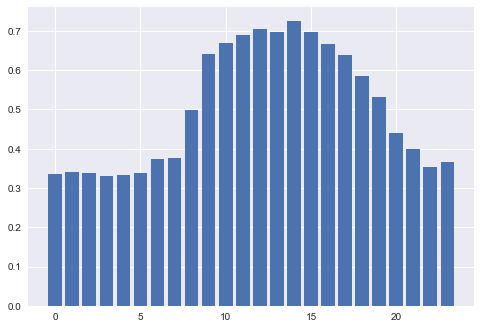

In [1007]:
tmp11=status[status.station_id==73].groupby('hour').mean()
tmp11
plt.bar(tmp11.index, tmp11.use_rate)
plt.show() #stationごとの時系列userate平均

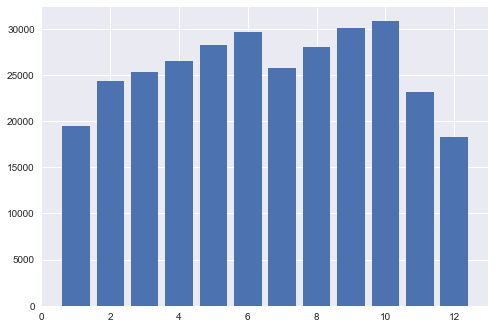

In [902]:
piyo=tmp2.groupby('mon').count()  #曜日ごとの集計
plt.bar(piyo.index, piyo.Duration)
plt.show()

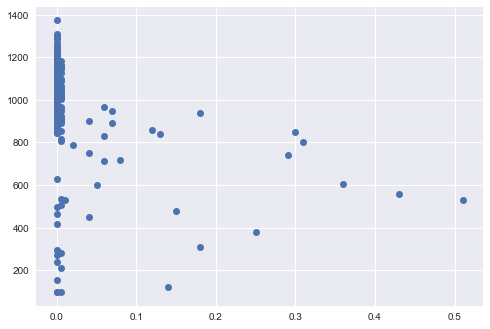

In [939]:
#tmp3=data.groupby('day')['start_lat','start_long'].count()
tmp3=data.groupby(['day','Start City']).start_lat.count().reset_index()
tmp3.rename(columns={'start_lat': 'cnt', 'Start City':'landmark'},inplace=True)
hoge=pd.merge(tmp3, tenki, how='left') #天候と件数をまとめた
hoge=hoge[hoge.landmark=='San Francisco']
hoge = hoge[hoge.day.dt.weekday < 5]
hoge.groupby('PrecipitationIn').count()
plt.plot(hoge['PrecipitationIn'], hoge.cnt,'o')
plt.show()

In [64]:
palo = data[data['Start City'] == 'Palo Alto'].dis
other = data[data['Start City'] != 'Palo Alto'].dis

In [890]:
data.groupby(["Start City", "End City"]).Duration.count().unstack() 
#行き先の市の組み合わせ

End City,Mountain View,Palo Alto,San Francisco,San Jose
Start City,,,,
Mountain View,6410.0,97.0,2.0,3.0
Palo Alto,105.0,2883.0,NaN,NaN
San Francisco,NaN,NaN,287507.0,4.0
San Jose,1.0,1.0,2.0,14974.0


In [944]:
status.groupby("station_id").use_rate.mean().sort_values(ascending=False).head() 
#station別使用率ランキング

station_id
91    0.833122
89    0.707337
62    0.692029
67    0.678979
59    0.656112
Name: use_rate, dtype: float64

In [922]:
data.groupby('Start City')['Duration', 'Subscriber Type'].mean()

,Duration,Subscriber Type
Start City,,
Mountain View,977.996622,0.158630
Palo Alto,2128.265060,0.323963
San Francisco,804.666952,0.100563
San Jose,923.938910,0.167646
